### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords # Модуль для загрузки стоп-слов
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel Токенизация текста
#!pip install razdel

import pymorphy2  # pip install pymorphy2 Модуль для получения нормальныой формы слова

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Илья\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 58.4 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 9min 14s


А теперь в 3 строчки обучим нашу модель

In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [14]:
from gensim.models import LdaModel

In [15]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 2min 6s


Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(6, 0.041824773),
 (7, 0.12151619),
 (13, 0.5464523),
 (16, 0.054931432),
 (19, 0.0372732),
 (23, 0.18068866)]

In [17]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: это год который российский россия военный свой
topic_1: путин россия президент владимир nn фестиваль агентство
topic_2: год млрд рубль цена рост это объём
topic_3: лауреат ресторан награда жюри медаль церемония удостоить
topic_4: операция год обнаружить проверка объект который врач
topic_5: человек женщина тело мужчина произойти результат который
topic_6: напомнить запуск ракета испытание флот корея экипаж
topic_7: украина украинский киев белоруссия это рейс больной
topic_8: фонд гражданин китай обращение японский китайский япония
topic_9: депутат высота федеральный годовой государственный служба собрание
topic_10: земля пациент nn вода город остров лечение
topic_11: погибнуть гражданин рак температура оборудование фронт фотография
topic_12: газ год дело который сотрудник nn станция
topic_13: который сша nn год первый новый группа
topic_14: тыс млн год составить выплата размер зарплата
topic_15: район мозг пострадать авария граница автомобиль образоваться
topic_16: препарат ст

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [18]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [19]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.082664,0.000000,0.000000,0.312707,0.0,0.000000,0.000000
1,4896,0.000000,0.0,0.0,0.0,0.0,0.0,0.152386,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.175318,0.000000,0.0,0.000000,0.568232
2,4897,0.000000,0.0,0.0,0.0,0.0,0.0,0.040560,0.121777,0.0,...,0.0,0.054987,0.0,0.000000,0.037367,0.000000,0.000000,0.0,0.178681,0.000000
3,4898,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.044731,0.000000,0.000000,0.0,0.585577,0.000000
4,4899,0.762792,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [20]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
doc_dict[293622]

array([0.07263608, 0.10169552, 0.        , 0.        , 0.        ,
       0.08683147, 0.        , 0.10173913, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09737952, 0.        ,
       0.        , 0.07731147, 0.01740242, 0.15324   , 0.        ,
       0.        , 0.18913436, 0.        , 0.07498258, 0.01915157])

## Задание 2, 3

In [23]:
def get_user_embedding(user_articles_list, method='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if method == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif method == 'median':
        user_vector = np.median(user_vector, 0)
    else:
        user_vector = np.max(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [24]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'mean'), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.096049,0.024047,0.014122,0.000000,0.003168,0.046871,0.0,0.096490,0.000000,...,0.004729,0.028735,0.002900,0.066201,0.187086,0.006857,0.089384,0.0,0.069510,0.042048
1,u108690,0.063753,0.015643,0.023297,0.000000,0.020902,0.036537,0.0,0.089096,0.019247,...,0.005672,0.000000,0.011247,0.020623,0.078423,0.000000,0.229695,0.0,0.180235,0.022701
2,u108339,0.114697,0.008258,0.052206,0.004762,0.049720,0.079993,0.0,0.000000,0.007349,...,0.015595,0.002278,0.020920,0.019241,0.044628,0.002401,0.142947,0.0,0.084704,0.076403


In [25]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'median'), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.101154,0.0,0.000000,0.0,0.000000,0.050220,0.0,0.086987,0.000000,...,0.000000,0.0,0.000000,0.000000,0.118022,0.0,0.015841,0.0,0.037491,0.009576
1,u108690,0.068119,0.0,0.009674,0.0,0.012214,0.009462,0.0,0.069015,0.000000,...,0.000000,0.0,0.005576,0.015466,0.066325,0.0,0.186745,0.0,0.155577,0.000000
2,u108339,0.071337,0.0,0.024075,0.0,0.040930,0.043530,0.0,0.000000,0.006427,...,0.008666,0.0,0.010856,0.000000,0.021237,0.0,0.133885,0.0,0.084889,0.081331


In [26]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'max'), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.217540,0.101696,0.084730,0.000000,0.019010,0.093956,0.0,0.303224,0.000000,...,0.028374,0.095100,0.017402,0.243964,0.592047,0.041143,0.315491,0.0,0.241500,0.196722
1,u108690,0.121330,0.051822,0.094301,0.000000,0.069059,0.144860,0.0,0.210577,0.115484,...,0.034034,0.000000,0.037917,0.060741,0.203365,0.000000,0.579062,0.0,0.419233,0.136204
2,u108339,0.267844,0.049549,0.139105,0.028572,0.137017,0.239316,0.0,0.000000,0.017294,...,0.056637,0.013669,0.079249,0.064328,0.160415,0.014407,0.357448,0.0,0.171633,0.104743


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [27]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [28]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.096049,0.024047,0.014122,0.000000,0.003168,0.046871,0.0,0.096490,0.000000,...,0.028735,0.002900,0.066201,0.187086,0.006857,0.089384,0.0,0.069510,0.042048,0
1,u108690,0.063753,0.015643,0.023297,0.000000,0.020902,0.036537,0.0,0.089096,0.019247,...,0.000000,0.011247,0.020623,0.078423,0.000000,0.229695,0.0,0.180235,0.022701,1
2,u108339,0.114697,0.008258,0.052206,0.004762,0.049720,0.079993,0.0,0.000000,0.007349,...,0.002278,0.020920,0.019241,0.044628,0.002401,0.142947,0.0,0.084704,0.076403,1


In [29]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.101154,0.0,0.000000,0.0,0.000000,0.050220,0.0,0.086987,0.000000,...,0.0,0.000000,0.000000,0.118022,0.0,0.015841,0.0,0.037491,0.009576,0
1,u108690,0.068119,0.0,0.009674,0.0,0.012214,0.009462,0.0,0.069015,0.000000,...,0.0,0.005576,0.015466,0.066325,0.0,0.186745,0.0,0.155577,0.000000,1
2,u108339,0.071337,0.0,0.024075,0.0,0.040930,0.043530,0.0,0.000000,0.006427,...,0.0,0.010856,0.000000,0.021237,0.0,0.133885,0.0,0.084889,0.081331,1


In [30]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.217540,0.101696,0.084730,0.000000,0.019010,0.093956,0.0,0.303224,0.000000,...,0.095100,0.017402,0.243964,0.592047,0.041143,0.315491,0.0,0.241500,0.196722,0
1,u108690,0.121330,0.051822,0.094301,0.000000,0.069059,0.144860,0.0,0.210577,0.115484,...,0.000000,0.037917,0.060741,0.203365,0.000000,0.579062,0.0,0.419233,0.136204,1
2,u108339,0.267844,0.049549,0.139105,0.028572,0.137017,0.239316,0.0,0.000000,0.017294,...,0.013669,0.079249,0.064328,0.160415,0.014407,0.357448,0.0,0.171633,0.104743,1


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
#разделим данные на train/test
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_mean['churn'], random_state=0)

X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(
    X_median[['topic_{}'.format(i) for i in range(25)]], X_median['churn'], random_state=0)

X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(
    X_max[['topic_{}'.format(i) for i in range(25)]], X_max['churn'], random_state=0)

In [34]:
logreg_mean = LogisticRegression()
logreg_median = LogisticRegression()
logreg_max = LogisticRegression()
#обучим 
logreg_mean.fit(X_train_mean, y_train_mean)
logreg_median.fit(X_train_median, y_train_median)
logreg_max.fit(X_train_max, y_train_max)

LogisticRegression()

In [35]:
#наши прогнозы для тестовой выборки
preds_mean = logreg_mean.predict_proba(X_test_mean)[:, 1]
print(preds_mean[:10])

preds_median = logreg_median.predict_proba(X_test_median)[:, 1]
print(preds_median[:10])

preds_max = logreg_max.predict_proba(X_test_max)[:, 1]
print(preds_max[:10])

[0.09256488 0.03204475 0.51071214 0.30719283 0.05952857 0.10910994
 0.04887251 0.0340148  0.02148937 0.0430986 ]
[0.08264669 0.01628886 0.67579058 0.46858656 0.03535495 0.10956014
 0.03522128 0.12102224 0.01275644 0.03619629]
[0.03157485 0.00787531 0.86277286 0.13665899 0.0140348  0.05207043
 0.00246645 0.04359387 0.00629383 0.09099225]


In [36]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [37]:
import itertools

In [40]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test_mean, preds_mean)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix_mean = np.argmax(fscore_mean)
print('Method = Mean. Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_mean[ix_mean], 
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean]))

precision_median, recall_median, thresholds_median = precision_recall_curve(y_test_median, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Method = Median. Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

precision_max, recall_max, thresholds_max = precision_recall_curve(y_test_max, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Method = Mean. Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Method = Mean. Best Threshold=0.278297, F-Score=0.738, Precision=0.698, Recall=0.784
Method = Median. Best Threshold=0.266695, F-Score=0.811, Precision=0.761, Recall=0.869
Method = Mean. Best Threshold=0.351506, F-Score=0.835, Precision=0.825, Recall=0.845


In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1672   83]
 [  54  191]]


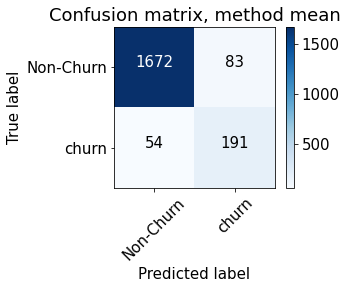

In [44]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_mean, preds_mean>thresholds_mean[ix_mean])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix, method mean')
# plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1688   67]
 [  33  212]]


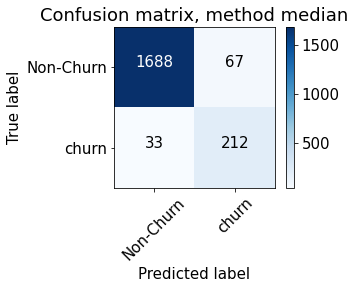

In [45]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_median, preds_median>thresholds_median[ix_median])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix, method median')
# plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1711   44]
 [  39  206]]


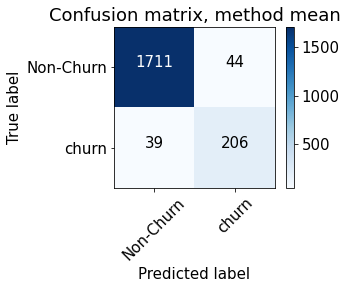

In [46]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_max, preds_max>thresholds_max[ix_max])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix, method mean')
# plt.savefig("conf_matrix.png")
plt.show()

In [47]:
roc_auc_mean = roc_auc_score(y_test_mean, preds_mean)
roc_auc_median = roc_auc_score(y_test_median, preds_median)
roc_auc_max = roc_auc_score(y_test_max, preds_max)

print(f'ROC AUC score for mean method: {roc_auc_mean}')
print(f'ROC AUC score for median method: {roc_auc_median}')
print(f'ROC AUC score for max method: {roc_auc_max}')

ROC AUC score for mean method: 0.9670957613814757
ROC AUC score for median method: 0.979538345252631
ROC AUC score for max method: 0.9833455433455432


## Задание 5.

Сформируем итоговую таблицу метрик для различных методов подсчета user embeddings:

In [51]:
report = pd.DataFrame(
    {
        'Precision': [precision_mean[ix_mean], precision_median[ix_median], precision_max[ix_max]],
        'Recall': [recall_mean[ix_mean], recall_median[ix_median], recall_max[ix_max]],
        'F1-score': [fscore_mean[ix_mean], fscore_median[ix_median], fscore_max[ix_max]],
        'ROC AUC score': [roc_auc_mean, roc_auc_median, roc_auc_max]
    },
    index=['Mean method', 'Median method', 'Max method']
)

report

,Precision,Recall,F1-score,ROC AUC score
Mean method,0.698182,0.783673,0.738462,0.967096
Median method,0.760714,0.869388,0.811429,0.979538
Max method,0.824701,0.844898,0.834677,0.983346


## Задание 6. Выводы.

Как видно, практически все метрики растут при смене методов расчета user embeddings: mean method -> median method -> max method. При смене median method на max method несущественно падает Recall.

Попробуем объяснить, почему так происходит.

Представим матрицу векторов статей пользователя. Столбцы - это статьи, строки - темы. Если у нас имеется несколько статей, с большой вероятностью отнесенных к определенной теме, а в остальных статьях будут нули на этой теме, то вместо того, чтобы четко соотнести интерес пользователя к этой теме, мы наоборот занижаем это значение взятием среднего. Поэтому результат получается самым худшим.

При взятии медианы мы часто зануляем значение "интереса" пользователя к тематике, если статей этой тематики недостаточно много. Но при этом хорошо улавливаем основные тематики интересов пользователя.

Как показал эксперимент, лучшим методом оказалось взятие максимума. При этом мы не уменьшаем и не зануляем средние и мелкие блоки тем, и также хорошо улавливаем крупные. То есть при таком методе подсчета, можно сказать, что модель хорошо улавливает и основные интересы пользователя, но также отмечает интерес к малочисленным, но хорошо кластеризованным статьям.